# Определение уровня шума аэродинамического профиля

## Техническое задание:

Разработать модель предсказания уровня шума [Дб] по заданным характеристикам профиля и потока

# Импорт библиотек

Стандартные библиотеки

In [1]:
import os
import sys
import pickle
from tqdm import tqdm
from colorama import Fore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,mean_squared_error

import tensorflow as tf
import torch

In [2]:
for lib in (pd, np, tf, torch):
    print(f'{lib.__name__}: {lib.__version__}')

pandas: 2.2.2
numpy: 1.26.4
tensorflow: 2.16.1
torch: 2.3.0+cpu


Частные библиотеки

In [3]:
sys.path.append('D:/Programming/Python/scripts')

In [4]:
from pandas_tools import DataFrame
#from ml_tools import SCALERS, DataFrame, Model, Stacking, Bagging, Boosting
from tensorflow_tools import training_plot, predictions_plot

# Определение констант

# Data Engeneering

## Импорт и визуализация исходных данных

In [5]:
for root, dirs, files in os.walk('datas'):
    if files:
        print('root: ', Fore.RED + root + Fore.RESET)
        print('directories: ', Fore.YELLOW + ', '.join(dirs) + Fore.RESET)
        print('files: ' + Fore.GREEN + ', '.join(files) + Fore.RESET)
        print()

root:  datas\external
directories:  
files: airfoil_self_noise.dat



In [6]:
df = pd.read_csv("datas/external/airfoil_self_noise.dat", sep="\t", header=None)
df = DataFrame(df)

In [7]:
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Предварительная обработка

In [8]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [9]:
df.columns

Index(['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]',
       'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]'],
      dtype='object')

Исходные данные:

1. Частота [Гц].
2. Угол атаки [град].
3. Длина хорды аэродинамического профиля [м].
4. Скорость набегающего потока [м/с].
5. Толщина аэродинамического профиля [м].

Результирующие данные:

6. Масштабированный уровень звукового давления [Дб].

In [26]:
target = 'Pressure level [db]'
df.target = target

## Обработка типов данных

In [11]:
df.info(memory_usage='deep')

<class 'pandas_tools.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Frequency [Hz]              1503 non-null   int64  
 1   Attack angle [deg]          1503 non-null   float64
 2   Chord length [m]            1503 non-null   float64
 3   Free-stream velocity [m/s]  1503 non-null   float64
 4   Thickness [m]               1503 non-null   float64
 5   Pressure level [db]         1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [12]:
categorials = df.select_dtypes(['object']).columns.to_list()
print(f'Категориальные признаки: {categorials}')

Категориальные признаки: []


In [13]:
numeric = df.select_dtypes(['int', 'float']).columns.to_list()
print(f'Числовые признаки: {numeric}')

Числовые признаки: ['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]', 'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]']


## Обработка локальных пустот и дубликатов

In [ ]:
df.isna().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

In [16]:
df[df.duplicated()].shape

(0, 6)

## Выделение признаков

## Обработка выбросов

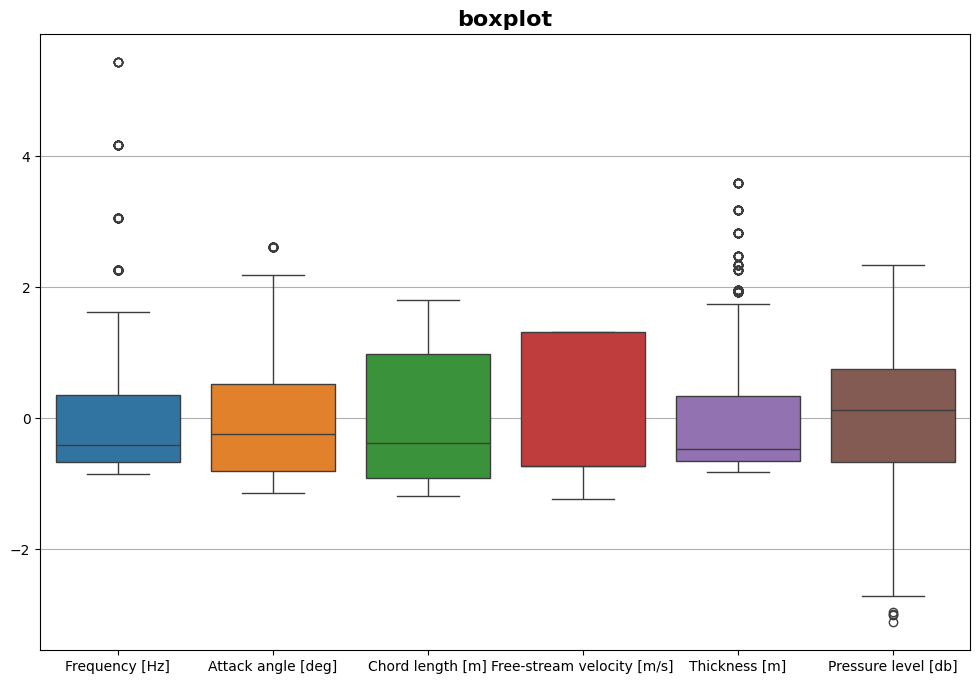

In [21]:
df.boxplot(scale=True, figsize=(12, 8), widths=1);

In [22]:
df.detect_outliers('sigma')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
28,12500,0.0,0.3048,55.5,0.002831,111.076
47,12500,0.0,0.3048,39.6,0.003101,109.619
78,12500,1.5,0.3048,71.3,0.003367,109.222
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
#df = df.drop(detect_outliers(df, 'sigma').index)

In [23]:
df.detect_outliers('Tukey')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
11,10000,0.0,0.3048,71.3,0.002663,115.391
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
27,10000,0.0,0.3048,55.5,0.002831,113.076
28,12500,0.0,0.3048,55.5,0.002831,111.076
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
#df = df.drop(detect_outliers(df, 'Tukey').index)

In [25]:
#df.detect_model_outliers(0.05, target=target)

NameError: name 'target' is not defined

# Анализ сбалансированности

In [ ]:
df.shape

(1503, 6)

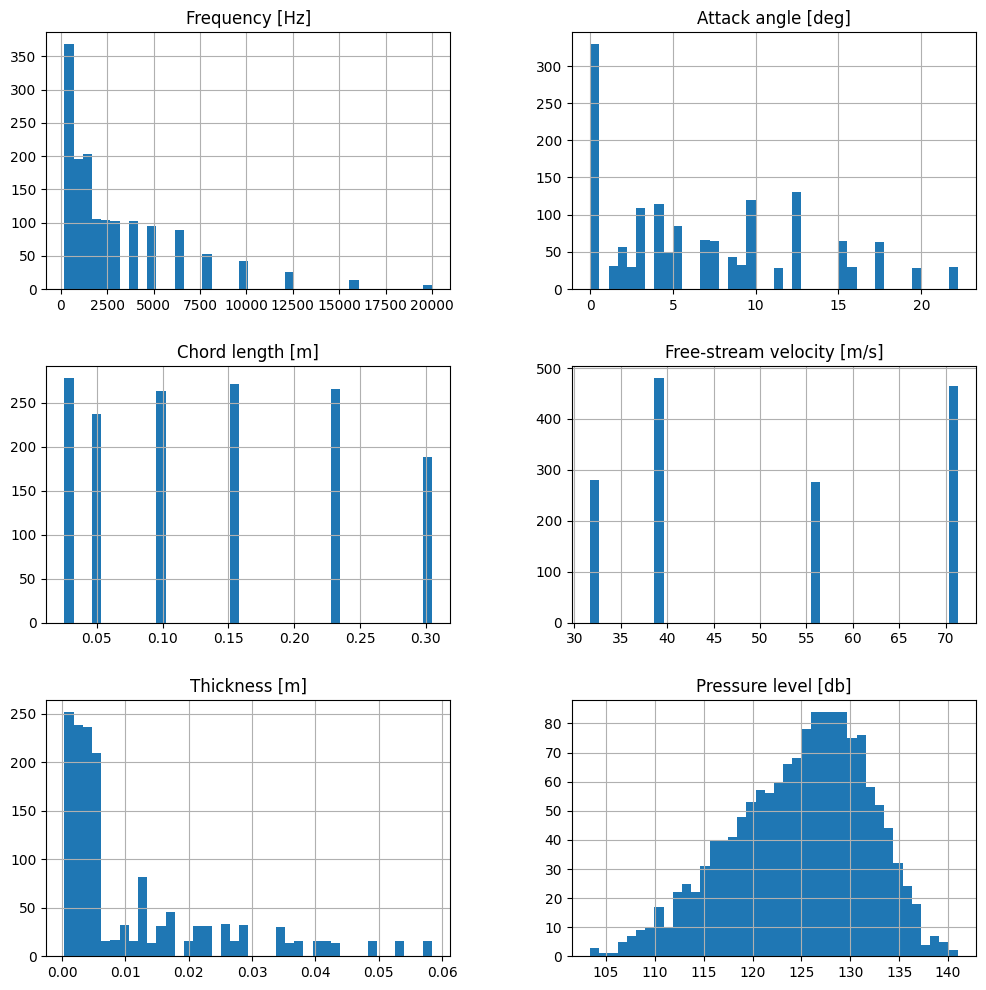

In [ ]:
df.histplot(figsize=(12, 12), bins=40, savefig=False)

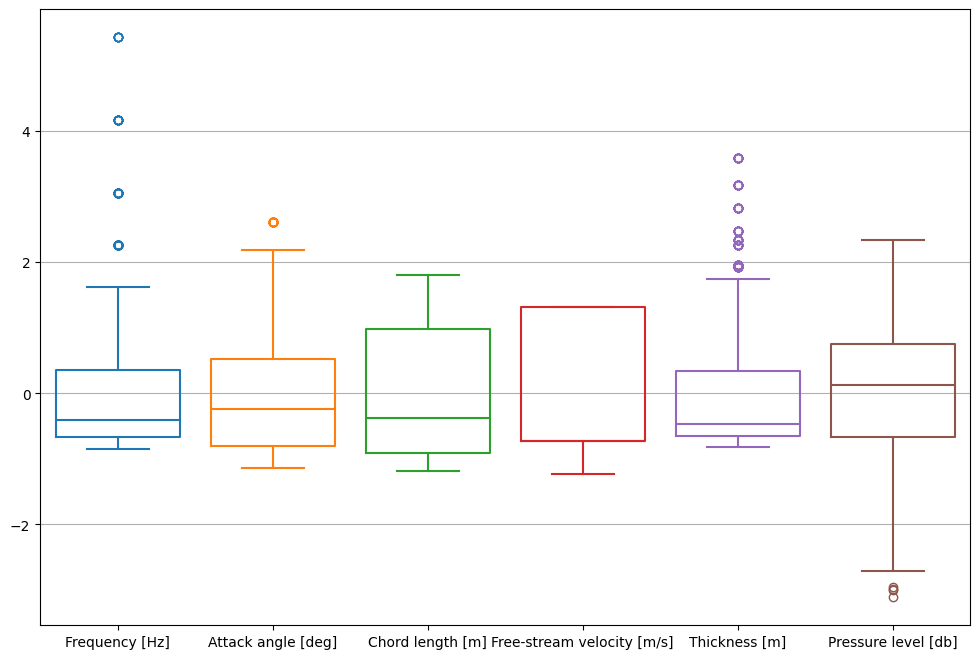

In [ ]:
df.boxplot(figsize=(12, 8), title='', scale=True, fill=False, grid=True, savefig=False)

In [ ]:
df.balance(target, threshold=2)

,count,fraction,balance
Pressure level [db],,,
127.315,3,0.001996,False
126.540,3,0.001996,False
129.395,3,0.001996,False
120.324,2,0.001331,False
110.905,2,0.001331,False
...,...,...,...
122.288,1,0.000665,False
122.235,1,0.000665,False
122.232,1,0.000665,False


# Визуализация данных

In [ ]:
#sns.pairplot(df);

In [ ]:
#df.pairplot(figsize=(15, 15), savefig=False)

# Корреляция данных

In [ ]:
corr = df.corr()

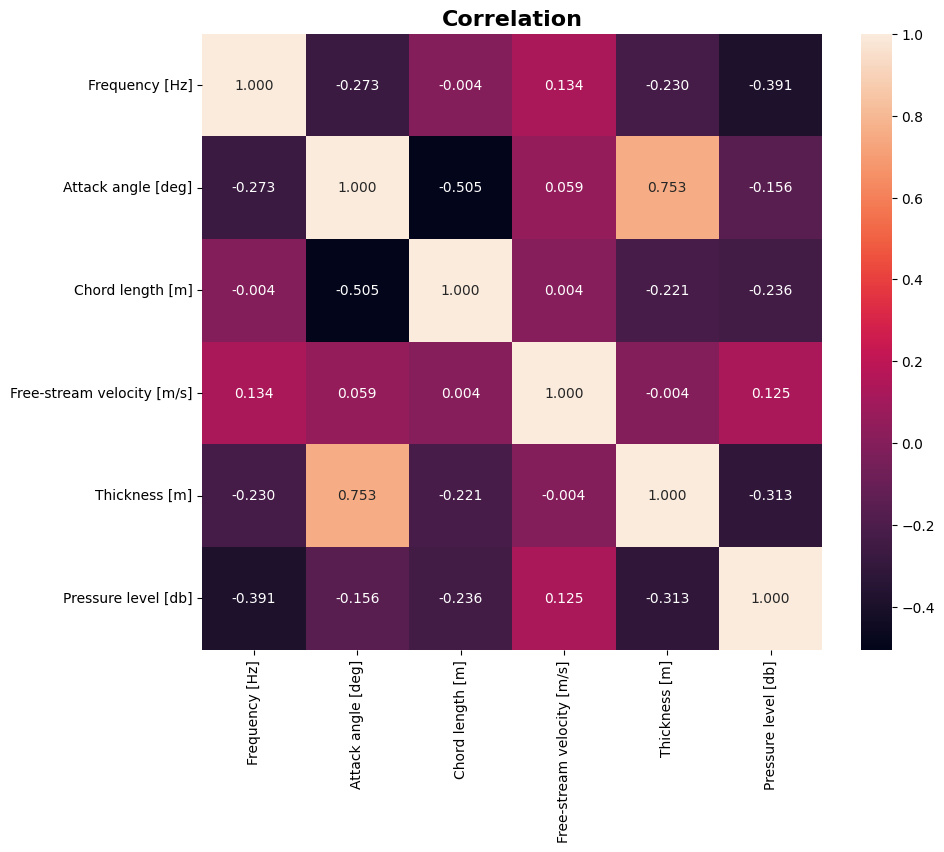

In [ ]:
df.corrplot(figsize=(10, 8), title='Correlation', fmt=3, savefig=False)

# Отбор признаков

## Линейно-независимые признаки

In [ ]:
corr_features = df.select_corr_features(threshold=0.85)
print('Линейно-независимые признаки:')
corr_features

Линейно-независимые признаки:


['Attack angle [deg]',
 'Chord length [m]',
 'Free-stream velocity [m/s]',
 'Thickness [m]',
 'Pressure level [db]']

In [ ]:
#df = df([corr_features])
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки с весомыми коэффициентами L1-регуляризации

Диапазон коэффициента L1-регуляризации

In [ ]:
l1 = list(2 ** np.linspace(-10, 2, 100))

In [ ]:
df.l1_importance(l1=l1, scale=True, early_stopping=True, target=target)

Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 966.97it/s]


,L1,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,0.000977,-4.038949,-2.492871,-3.334658,1.553049,-1.936845
1,0.001062,-4.038779,-2.492594,-3.334439,1.552923,-1.936882
2,0.001155,-4.038593,-2.492293,-3.334202,1.552787,-1.936921
3,0.001257,-4.038392,-2.491965,-3.333943,1.552638,-1.936964
4,0.001367,-4.038172,-2.491609,-3.333662,1.552476,-1.937010
...,...,...,...,...,...,...
95,2.858288,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
96,3.108813,NaN,NaN,NaN,NaN,NaN
97,3.381295,NaN,NaN,NaN,NaN,NaN
98,3.677659,NaN,NaN,NaN,NaN,NaN


Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 1230.63it/s]


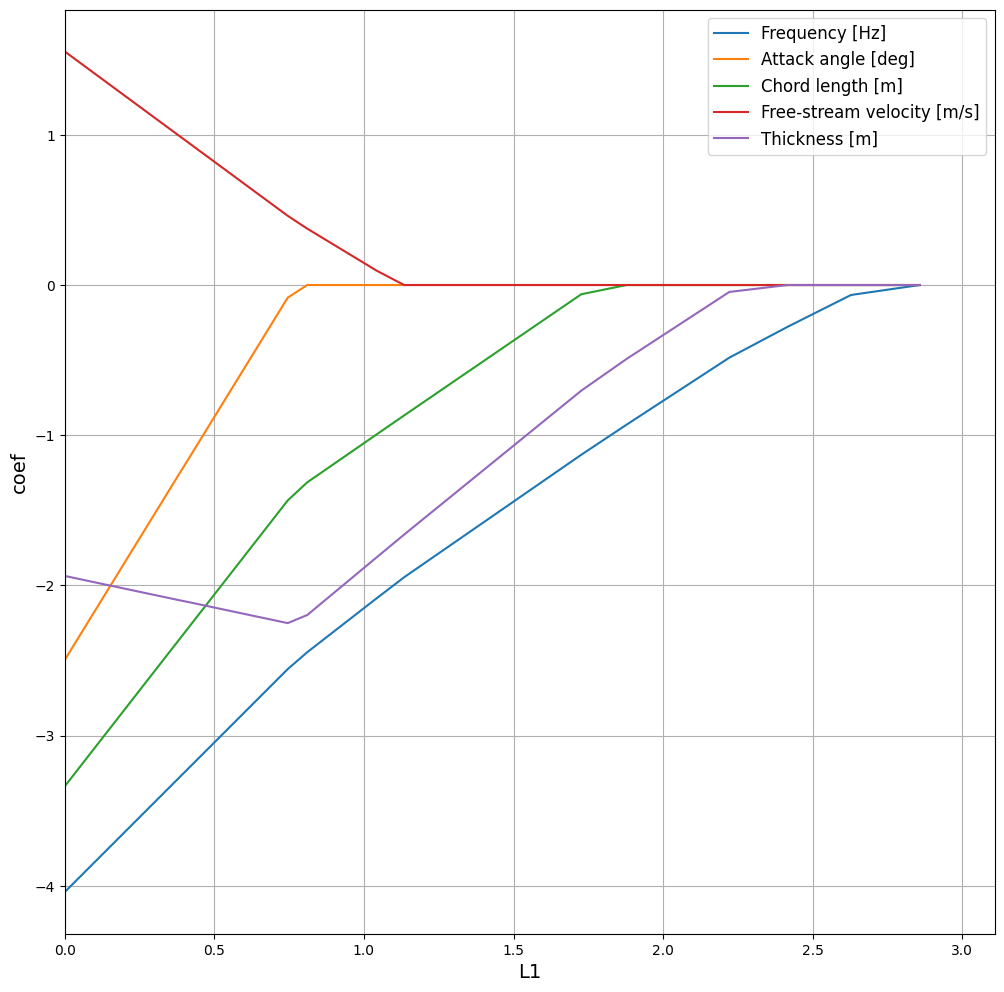

In [ ]:
df.l1_importance_plot(l1=l1, scale=True, early_stopping=True, figsize=(12, 12), target=target)

In [ ]:
l1_features = df.select_l1_features(5, l1=l1, scale=True, early_stopping=True, target=target)
print('Признаки с весомыми коэффициентами L1-регуляризации:')
l1_features

Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 1152.53it/s]


Признаки с весомыми коэффициентами L1-регуляризации:


['Frequency [Hz]',
 'Attack angle [deg]',
 'Chord length [m]',
 'Free-stream velocity [m/s]',
 'Thickness [m]']

In [ ]:
#df = df[l1_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки без взаимной информации корреляции

In [ ]:
mutual_info_score = df.mutual_info_score(target=target)
mutual_info_score

Thickness [m]                 4.602460
Attack angle [deg]            2.980877
Frequency [Hz]                2.876181
Chord length [m]              1.754163
Free-stream velocity [m/s]    1.327654
dtype: float64

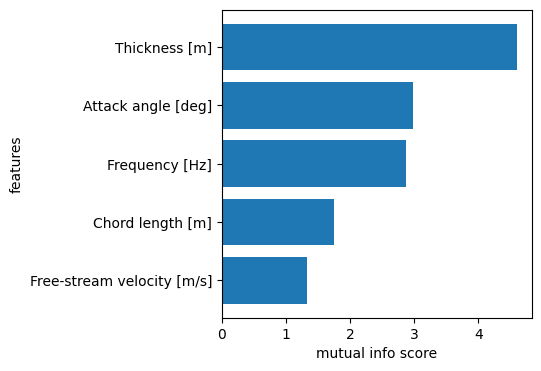

In [ ]:
df.mutual_info_score_plot(figsize=(4,4), target=target)

In [ ]:
mutual_info_score_features = df.select_mutual_info_score_features(5, target=target)
print('Признаки без взаимной информации кореляции:')
mutual_info_score_features

Признаки без взаимной информации кореляции:


['Thickness [m]',
 'Attack angle [deg]',
 'Frequency [Hz]',
 'Chord length [m]',
 'Free-stream velocity [m/s]']

In [ ]:
#df = df[mutual_info_score_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки, выбранные перемешивающим методом

In [ ]:
df.permutation_importance(target=target)

Frequency [Hz]                1.514714
Thickness [m]                 0.948189
Chord length [m]              0.287621
Free-stream velocity [m/s]    0.103869
Attack angle [deg]            0.082901
dtype: float64

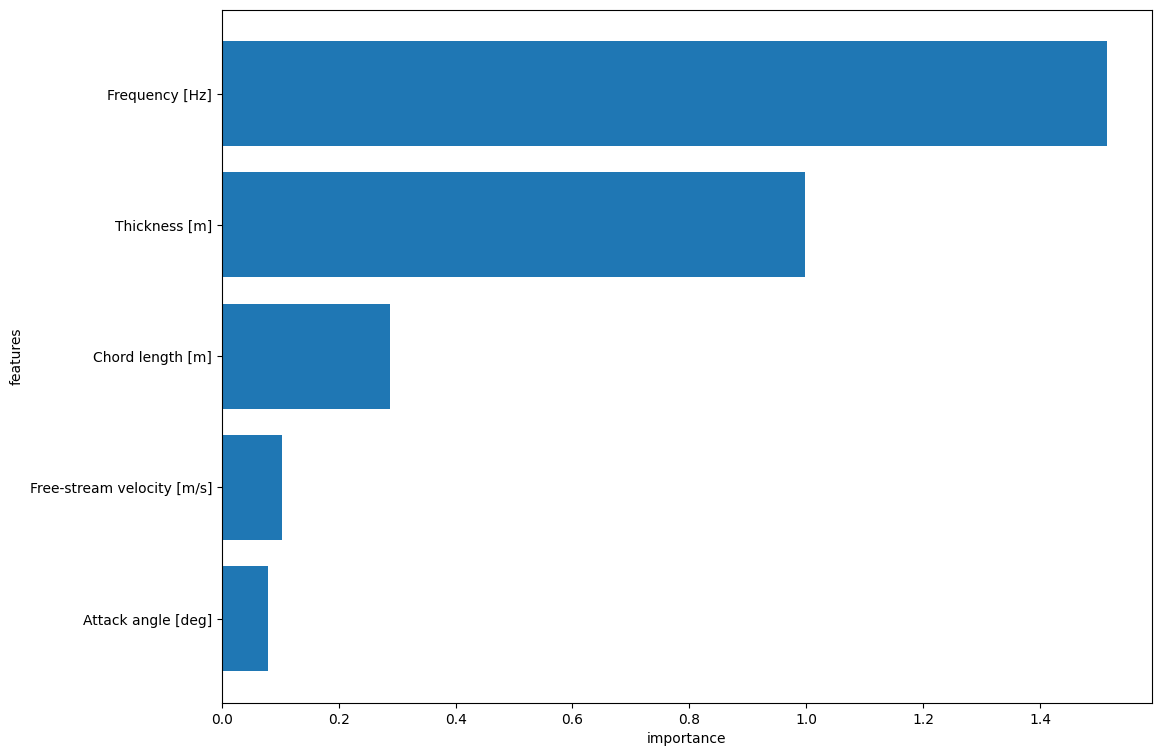

In [ ]:
df.permutation_importance_plot(figsize=(12, 9), target=target)

In [ ]:
permutation_importance_features = df.select_permutation_importance_features(5, target=target)
print('Признаки, выбранные перемешивающим методом:')
permutation_importance_features

Признаки, выбранные перемешивающим методом:


['Frequency [Hz]',
 'Thickness [m]',
 'Chord length [m]',
 'Free-stream velocity [m/s]',
 'Attack angle [deg]']

In [ ]:
#df = df[permutation_importance_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки важные для случайного леса

In [ ]:
df.random_forest_importance_features(target=target)

Thickness [m]                 0.429010
Frequency [Hz]                0.391478
Chord length [m]              0.092951
Attack angle [deg]            0.043585
Free-stream velocity [m/s]    0.042976
dtype: float64

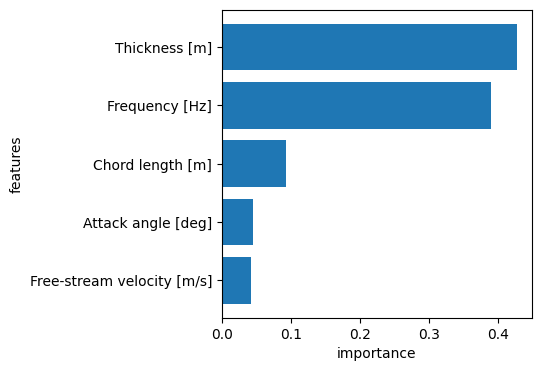

In [ ]:
df.random_forest_importance_features_plot(figsize=(4, 4), target=target)

In [ ]:
random_forest_importance_features = df.select_random_forest_importance_features(5, target=target)
print('Признаки важные для случайного леса:')
random_forest_importance_features

Признаки важные для случайного леса:


['Thickness [m]',
 'Frequency [Hz]',
 'Chord length [m]',
 'Attack angle [deg]',
 'Free-stream velocity [m/s]']

In [ ]:
#df = df[random_forest_importance_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## k лучших признаков

In [ ]:
k_best_features = df.select_k_best_features('f_regression', 5, test_size=0.25, target=target)
print('k лучших признаков:')
k_best_features

score: 0.21969858889212013
k лучших признаков:


['Frequency [Hz]',
 'Attack angle [deg]',
 'Chord length [m]',
 'Free-stream velocity [m/s]',
 'Thickness [m]']

In [ ]:
#df = df[k_best_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## % лучших признаков

In [ ]:
percentile_features = df.select_percentile_features('f_regression', 80, test_size=0.25, target=target)
print('% лучших признаков:')
percentile_features

score: 0.4229139331102636
% лучших признаков:


,Frequency [Hz],Attack angle [deg],Chord length [m],Thickness [m]
0,800.0,0.0,0.3048,0.002663
1,1000.0,0.0,0.3048,0.002663
2,1250.0,0.0,0.3048,0.002663
3,1600.0,0.0,0.3048,0.002663
4,2000.0,0.0,0.3048,0.002663
...,...,...,...,...
1498,2500.0,15.6,0.1016,0.052849
1499,3150.0,15.6,0.1016,0.052849
1500,4000.0,15.6,0.1016,0.052849
1501,5000.0,15.6,0.1016,0.052849


In [ ]:
#df = df[percentile_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## k лучших признаков, выбранных путем рекурсивного удаления худших

In [ ]:
elimination_features = df.select_elimination_features(5, 1, test_size=0.25, target=target)
print('k лучших признаков, выбранных путем рекурсивного удаления худших:')
elimination_features

score: 0.9335749220976913
k лучших признаков, выбранных путем рекурсивного удаления худших:


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800.0,0.0,0.3048,71.3,0.002663
1,1000.0,0.0,0.3048,71.3,0.002663
2,1250.0,0.0,0.3048,71.3,0.002663
3,1600.0,0.0,0.3048,71.3,0.002663
4,2000.0,0.0,0.3048,71.3,0.002663
...,...,...,...,...,...
1498,2500.0,15.6,0.1016,39.6,0.052849
1499,3150.0,15.6,0.1016,39.6,0.052849
1500,4000.0,15.6,0.1016,39.6,0.052849
1501,5000.0,15.6,0.1016,39.6,0.052849


In [ ]:
#df = df[elimination_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки, выбранные из модели случайного леса

In [ ]:
from_model_features = df.select_from_model_features(5, target=target)
print('Признаки, выбранные из модели случайного леса:')
from_model_features

Признаки, выбранные из модели случайного леса:


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800.0,0.0,0.3048,71.3,0.002663
1,1000.0,0.0,0.3048,71.3,0.002663
2,1250.0,0.0,0.3048,71.3,0.002663
3,1600.0,0.0,0.3048,71.3,0.002663
4,2000.0,0.0,0.3048,71.3,0.002663
...,...,...,...,...,...
1498,2500.0,15.6,0.1016,39.6,0.052849
1499,3150.0,15.6,0.1016,39.6,0.052849
1500,4000.0,15.6,0.1016,39.6,0.052849
1501,5000.0,15.6,0.1016,39.6,0.052849


In [ ]:
#df = df[from_model_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Признаки, выбранные последовательно

In [ ]:
%%time
sequential_features = df.select_sequential_features(4, 'forward', test_size=0.25, target=target)
print('Признаки, выбранные последовательно:')
sequential_features

score: 0.9284926431311739
Признаки, выбранные последовательно:
CPU times: total: 12.6 s
Wall time: 12.8 s


,Frequency [Hz],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800.0,0.3048,71.3,0.002663
1,1000.0,0.3048,71.3,0.002663
2,1250.0,0.3048,71.3,0.002663
3,1600.0,0.3048,71.3,0.002663
4,2000.0,0.3048,71.3,0.002663
...,...,...,...,...
1498,2500.0,0.1016,39.6,0.052849
1499,3150.0,0.1016,39.6,0.052849
1500,4000.0,0.1016,39.6,0.052849
1501,5000.0,0.1016,39.6,0.052849


In [ ]:
#df = df[sequential_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
%%time
sequential_features = df.select_sequential_features(4, 'backward', test_size=0.25, target=target)
print('Признаки, выбранные последовательно:')
sequential_features

score: 0.9290409739536699
Признаки, выбранные последовательно:
CPU times: total: 6.52 s
Wall time: 6.54 s


,Frequency [Hz],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800.0,0.3048,71.3,0.002663
1,1000.0,0.3048,71.3,0.002663
2,1250.0,0.3048,71.3,0.002663
3,1600.0,0.3048,71.3,0.002663
4,2000.0,0.3048,71.3,0.002663
...,...,...,...,...
1498,2500.0,0.1016,39.6,0.052849
1499,3150.0,0.1016,39.6,0.052849
1500,4000.0,0.1016,39.6,0.052849
1501,5000.0,0.1016,39.6,0.052849


In [ ]:
#df = df[sequential_features]
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


# Понижение размерности

In [ ]:
df.pca(1, test_size=0.25, target=target)

Объем сохраненной и потерянной информации: [0.99997277]
Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [ ]:
df.lda(4, test_size=0.25, target=target)

Unknown label type: (array([126.201, 125.201, 125.951, ..., 106.604, 106.224, 104.204]),)


In [ ]:
df.nca(5, test_size=0.25, target=target)

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


## Анализ необходимости нормализации и скалирования

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Attack angle [deg],1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
Chord length [m],1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Free-stream velocity [m/s],1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Thickness [m],1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
Pressure level [db],1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


In [ ]:
scaler = SCALERS[1]()
scaler

StandardScaler()

In [ ]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,-0.662023,-1.146403,1.799299,1.312935,-0.644805,0.197939
1,-0.598561,-1.146403,1.799299,1.312935,-0.644805,0.052935
2,-0.519235,-1.146403,1.799299,1.312935,-0.644805,0.161688
3,-0.408177,-1.146403,1.799299,1.312935,-0.644805,0.399494
4,-0.281255,-1.146403,1.799299,1.312935,-0.644805,0.380644
...,...,...,...,...,...,...
1498,-0.122601,1.490443,-0.373740,-0.723345,3.172773,-2.112990
1499,0.083648,1.490443,-0.373740,-0.723345,3.172773,-2.259444
1500,0.353359,1.490443,-0.373740,-0.723345,3.172773,-2.643705
1501,0.670666,1.490443,-0.373740,-0.723345,3.172773,-2.698806


# Разделение данных для обучения и тестирования

In [ ]:
test_size = 0.2
shuffle = True
random_state = 0

In [ ]:
df_train, df_test = df.train_test_split(test_size=test_size, shuffle=shuffle, random_state=random_state)

In [ ]:
df_train.shape, df_test.shape

((1202, 6), (301, 6))

# Разделение данных на признаки и целевую функцию

In [ ]:
df_train_x = df_train.copy()
df_train_y = df_train_x.pop(target)

Проверка разделения тренировочных даннных

In [ ]:
pd.concat([df_train_x, df_train_y], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
1058,800,9.5,0.0254,71.3,0.004207,127.206
408,315,7.3,0.2286,55.5,0.011171,136.284
703,2000,12.6,0.1524,71.3,0.048316,117.504
1279,8000,0.0,0.1016,39.6,0.001463,122.341
140,6300,3.0,0.3048,39.6,0.004957,114.042
...,...,...,...,...,...,...
763,12500,0.0,0.0508,39.6,0.000792,123.988
835,1250,8.4,0.0508,31.7,0.005808,130.156
1216,1250,22.2,0.0254,71.3,0.021418,140.987
559,1250,5.4,0.1524,55.5,0.004333,130.777


Проверка разделения тестовых даннных

In [ ]:
df_test_x = df_test.copy()
df_test_y = df_test_x.pop(target)

In [ ]:
pd.concat([df_test_x, df_test_y], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
968,10000,0.0,0.0254,71.3,0.000401,130.787
9,6300,0.0,0.3048,71.3,0.002663,119.541
1468,2500,12.3,0.1016,31.7,0.041876,110.317
1150,400,17.4,0.0254,71.3,0.016104,117.396
880,2500,15.4,0.0508,71.3,0.026427,127.625
...,...,...,...,...,...,...
1189,1600,17.4,0.0254,39.6,0.017221,127.614
220,1000,0.0,0.2286,39.6,0.002535,130.435
489,1600,0.0,0.1524,39.6,0.001933,131.013
381,1000,5.3,0.2286,39.6,0.006143,125.581


# ML

## Поиск лучшей модели

Определение объекта модели

In [ ]:
model = Model(None)

In [ ]:
models = model.fit_all(df_train_x, df_train_y, exceptions=False)

100%|██████████| 48/48 [00:02<00:00, 19.53it/s] 


In [ ]:
warnings.filterwarnings('ignore')

errors, scores = dict(), dict()

for model in tqdm(models):
    try:
        predictions = model.predict(df_test_x)
        errors[str(model)] = model.errors(df_test_y, predictions, exceptions=False)
        scores[str(model)] = model.scores(df_test_y, predictions, exceptions=False)
    except:
        pass    
    
warnings.filterwarnings('default')

100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


In [ ]:
errors = DataFrame(errors)
errors

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010,4.454955,3.545248,4.455010,4.775870,3.551563,4.934883,...,4.724528,NaN,1.667193,1.998671,1.253585,1.066129,1.406100,1.938778,3.202716,1.221394
mean_squared_error,15374.035087,20.765101,22.319791,32.184320,32.086592,20.765101,32.184320,39.243295,20.793224,36.923887,...,37.545406,NaN,5.348311,7.434368,3.040922,2.256135,4.141772,6.866024,15.873506,3.155005
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123,5.664503,4.556874,5.673123,6.264447,4.559959,6.076503,...,6.127431,NaN,2.312642,2.726604,1.743824,1.502044,2.035134,2.620310,3.984157,1.776233
max_error,137.758000,15.344562,14.958278,16.823379,16.818112,15.344562,16.823381,19.395758,15.234636,16.863000,...,17.553000,NaN,13.590000,12.372000,9.678040,7.165540,12.032500,10.790129,10.467500,9.351129
mean_absolute_percentage_error,0.991962,0.028530,0.029844,0.036146,0.036139,0.028530,0.036146,0.038925,0.028589,0.040157,...,0.038280,NaN,0.013444,0.016075,0.010116,0.008623,0.011359,0.015564,0.025989,0.009853
median_absolute_error,124.951000,2.758977,3.058168,3.575059,3.591656,2.758977,3.575061,3.788477,2.789413,4.043117,...,3.662800,NaN,1.338000,1.515000,0.940560,0.779500,1.039400,1.443202,2.539866,0.844990
mean_squared_log_error,17.142996,0.001321,0.001445,0.002108,0.002101,0.001321,0.002108,0.002584,0.001324,0.002424,...,0.002445,NaN,0.000337,0.000464,0.000193,0.000145,0.000261,0.000431,0.001032,0.000199
root_mean_squared_log_error,4.140410,0.036350,0.038013,0.045912,0.045833,0.036350,0.045912,0.050833,0.036393,0.049235,...,0.049444,NaN,0.018369,0.021530,0.013895,0.012036,0.016157,0.020754,0.032122,0.014109


In [ ]:
scores = DataFrame(scores)
scores

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.863005e-01,8.419531e-01,0.935353,0.952037,0.91195,8.540355e-01,6.625459e-01,0.932928
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.875126e-01,6.253826e-01,0.765037,0.800172,0.73645,6.366085e-01,3.997045e-01,0.771070
rand_score,0.000000,1.000000,1.000000,9.992248e-01,9.992248e-01,1.000000,9.992248e-01,9.453378e-01,1.000000,9.901883e-01,...,9.986268e-01,NaN,9.988261e-01,9.986489e-01,1.000000,1.000000,1.00000,9.998893e-01,9.856035e-01,1.000000
adjusted_rand_score,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,...,0.000000e+00,NaN,0.000000e+00,0.000000e+00,1.000000,1.000000,1.00000,0.000000e+00,0.000000e+00,1.000000
completeness_score,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000,1.000000,1.00000,1.000000e+00,1.000000e+00,1.000000
homogeneity_score,0.000000,1.000000,1.000000,9.743739e-01,9.743739e-01,1.000000,9.743739e-01,5.116095e-01,1.000000,7.782914e-01,...,9.552037e-01,NaN,9.612483e-01,9.565131e-01,1.000000,1.000000,1.00000,9.959650e-01,7.784215e-01,1.000000
v_measure_score,0.000000,1.000000,1.000000,9.870206e-01,9.870206e-01,1.000000,9.870206e-01,6.769070e-01,1.000000,8.753249e-01,...,9.770887e-01,NaN,9.802413e-01,9.777733e-01,1.000000,1.000000,1.00000,9.979784e-01,8.754072e-01,1.000000
d2_tweedie_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.863005e-01,8.419531e-01,0.935353,0.952037,0.91195,8.540355e-01,6.625459e-01,0.932928
d2_pinball_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.875126e-01,6.253826e-01,0.765037,0.800172,0.73645,6.366085e-01,3.997045e-01,0.771070
mutual_info_score,0.000000,5.707110,5.707110,5.560859e+00,5.560859e+00,5.707110,5.560859e+00,2.919812e+00,5.707110,4.441795e+00,...,5.451453e+00,NaN,5.485950e+00,5.458926e+00,5.707110,5.707110,5.70711,5.684082e+00,4.442537e+00,5.707110


In [ ]:
stats = pd.concat([errors, scores], axis=0)
stats

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,KNeighborsRegressor(),RadiusNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010e+00,4.454955e+00,3.545248,4.455010e+00,4.775870e+00,3.551563,4.934883e+00,...,4.724528e+00,NaN,1.667193e+00,1.998671e+00,1.253585,1.066129,1.406100,1.938778e+00,3.202716e+00,1.221394
mean_squared_error,15374.035087,20.765101,22.319791,3.218432e+01,3.208659e+01,20.765101,3.218432e+01,3.924329e+01,20.793224,3.692389e+01,...,3.754541e+01,NaN,5.348311e+00,7.434368e+00,3.040922,2.256135,4.141772,6.866024e+00,1.587351e+01,3.155005
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123e+00,5.664503e+00,4.556874,5.673123e+00,6.264447e+00,4.559959,6.076503e+00,...,6.127431e+00,NaN,2.312642e+00,2.726604e+00,1.743824,1.502044,2.035134,2.620310e+00,3.984157e+00,1.776233
max_error,137.758000,15.344562,14.958278,1.682338e+01,1.681811e+01,15.344562,1.682338e+01,1.939576e+01,15.234636,1.686300e+01,...,1.755300e+01,NaN,1.359000e+01,1.237200e+01,9.678040,7.165540,12.032500,1.079013e+01,1.046750e+01,9.351129
mean_absolute_percentage_error,0.991962,0.028530,0.029844,3.614626e-02,3.613933e-02,0.028530,3.614626e-02,3.892451e-02,0.028589,4.015658e-02,...,3.828003e-02,NaN,1.344420e-02,1.607476e-02,0.010116,0.008623,0.011359,1.556414e-02,2.598933e-02,0.009853
median_absolute_error,124.951000,2.758977,3.058168,3.575059e+00,3.591656e+00,2.758977,3.575061e+00,3.788477e+00,2.789413,4.043117e+00,...,3.662800e+00,NaN,1.338000e+00,1.515000e+00,0.940560,0.779500,1.039400,1.443202e+00,2.539866e+00,0.844990
mean_squared_log_error,17.142996,0.001321,0.001445,2.107916e-03,2.100638e-03,0.001321,2.107916e-03,2.584038e-03,0.001324,2.424084e-03,...,2.444724e-03,NaN,3.374157e-04,4.635608e-04,0.000193,0.000145,0.000261,4.307142e-04,1.031849e-03,0.000199
root_mean_squared_log_error,4.140410,0.036350,0.038013,4.591204e-02,4.583271e-02,0.036350,4.591204e-02,5.083343e-02,0.036393,4.923499e-02,...,4.944415e-02,NaN,1.836888e-02,2.153046e-02,0.013895,0.012036,0.016157,2.075366e-02,3.212240e-02,0.014109
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,2.018241e-01,NaN,8.863005e-01,8.419531e-01,0.935353,0.952037,0.911950,8.540355e-01,6.625459e-01,0.932928
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.144663e-01,NaN,6.875126e-01,6.253826e-01,0.765037,0.800172,0.736450,6.366085e-01,3.997045e-01,0.771070


Удаление неподходящих моделей с отрицательными метриками

In [ ]:
stats = stats.transpose()
stats = stats[(stats >= 0).all(axis=1)]
stats = stats.transpose()
stats

,LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),RANSACRegressor(),...,TheilSenRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,4.455010e+00,4.454955e+00,3.545248,4.455010e+00,4.775870e+00,3.551563,4.934883e+00,3.954384,...,3.616997,4.724528e+00,1.667193e+00,1.998671e+00,1.253585,1.066129,1.406100,1.938778e+00,3.202716e+00,1.221394
mean_squared_error,20.765101,22.319791,3.218432e+01,3.208659e+01,20.765101,3.218432e+01,3.924329e+01,20.793224,3.692389e+01,27.342400,...,24.202183,3.754541e+01,5.348311e+00,7.434368e+00,3.040922,2.256135,4.141772,6.866024e+00,1.587351e+01,3.155005
root_mean_squared_error,4.556874,4.724383,5.673123e+00,5.664503e+00,4.556874,5.673123e+00,6.264447e+00,4.559959,6.076503e+00,5.228996,...,4.919571,6.127431e+00,2.312642e+00,2.726604e+00,1.743824,1.502044,2.035134,2.620310e+00,3.984157e+00,1.776233
max_error,15.344562,14.958278,1.682338e+01,1.681811e+01,15.344562,1.682338e+01,1.939576e+01,15.234636,1.686300e+01,17.130060,...,19.004554,1.755300e+01,1.359000e+01,1.237200e+01,9.678040,7.165540,12.032500,1.079013e+01,1.046750e+01,9.351129
mean_absolute_percentage_error,0.028530,0.029844,3.614626e-02,3.613933e-02,0.028530,3.614626e-02,3.892451e-02,0.028589,4.015658e-02,0.032013,...,0.029059,3.828003e-02,1.344420e-02,1.607476e-02,0.010116,0.008623,0.011359,1.556414e-02,2.598933e-02,0.009853
median_absolute_error,2.758977,3.058168,3.575059e+00,3.591656e+00,2.758977,3.575061e+00,3.788477e+00,2.789413,4.043117e+00,3.216328,...,2.957666,3.662800e+00,1.338000e+00,1.515000e+00,0.940560,0.779500,1.039400,1.443202e+00,2.539866e+00,0.844990
mean_squared_log_error,0.001321,0.001445,2.107916e-03,2.100638e-03,0.001321,2.107916e-03,2.584038e-03,0.001324,2.424084e-03,0.001784,...,0.001577,2.444724e-03,3.374157e-04,4.635608e-04,0.000193,0.000145,0.000261,4.307142e-04,1.031849e-03,0.000199
root_mean_squared_log_error,0.036350,0.038013,4.591204e-02,4.583271e-02,0.036350,4.591204e-02,5.083343e-02,0.036393,4.923499e-02,0.042240,...,0.039712,4.944415e-02,1.836888e-02,2.153046e-02,0.013895,0.012036,0.016157,2.075366e-02,3.212240e-02,0.014109
r2_score,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,0.418729,...,0.485487,2.018241e-01,8.863005e-01,8.419531e-01,0.935353,0.952037,0.911950,8.540355e-01,6.625459e-01,0.932928
d2_absolute_error_score,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,0.258817,...,0.322055,1.144663e-01,6.875126e-01,6.253826e-01,0.765037,0.800172,0.736450,6.366085e-01,3.997045e-01,0.771070


In [ ]:
cmap = sns.color_palette('coolwarm', as_cmap=True)
stats.style.background_gradient(cmap=cmap)

,LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),RANSACRegressor(),PoissonRegressor(),HuberRegressor(),TweedieRegressor(),QuantileRegressor(),TheilSenRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,4.455010,4.454955,3.545248,4.455010,4.775870,3.551563,4.934883,3.662356,3.960220,5.154495,4.446718,4.784956,3.581670,4.724528,1.705113,1.815478,1.282171,1.074166,1.446499,1.938778,3.234304,1.221394
mean_squared_error,20.765101,22.319791,32.184320,32.086592,20.765101,32.184320,39.243295,20.793224,36.923887,25.631708,25.430791,42.962856,31.879186,40.029213,23.515167,37.545406,5.942019,5.965353,3.375733,2.376566,3.717331,6.866024,15.873220,3.155005
root_mean_squared_error,4.556874,4.724383,5.673123,5.664503,4.556874,5.673123,6.264447,4.559959,6.076503,5.062777,5.042895,6.554606,5.646166,6.326864,4.849244,6.127431,2.437626,2.442407,1.837317,1.541612,1.928038,2.620310,3.984121,1.776233
max_error,15.344562,14.958278,16.823379,16.818112,15.344562,16.823381,19.395758,15.234636,16.863000,18.846986,15.494579,20.291632,16.777574,18.913384,18.199127,17.553000,13.858000,16.369000,10.890690,6.875320,9.136600,10.790129,9.864560,9.351129
mean_absolute_percentage_error,0.028530,0.029844,0.036146,0.036139,0.028530,0.036146,0.038925,0.028589,0.040157,0.029358,0.032104,0.041608,0.036066,0.038962,0.028783,0.038280,0.013783,0.014657,0.010367,0.008696,0.011687,0.015564,0.026239,0.009853
median_absolute_error,2.758977,3.058168,3.575059,3.591656,2.758977,3.575061,3.788477,2.789413,4.043117,2.608916,3.263319,4.286890,3.676287,3.675391,2.863807,3.662800,1.338000,1.440000,0.951300,0.776550,1.118800,1.443202,2.751590,0.844990
mean_squared_log_error,0.001321,0.001445,0.002108,0.002101,0.001321,0.002108,0.002584,0.001324,0.002424,0.001657,0.001660,0.002809,0.002086,0.002645,0.001523,0.002445,0.000376,0.000378,0.000214,0.000153,0.000238,0.000431,0.001029,0.000199
root_mean_squared_log_error,0.036350,0.038013,0.045912,0.045833,0.036350,0.045912,0.050833,0.036393,0.049235,0.040704,0.040740,0.052998,0.045675,0.051432,0.039032,0.049444,0.019399,0.019451,0.014618,0.012353,0.015418,0.020754,0.032074,0.014109
r2_score,0.558556,0.525505,0.315795,0.317873,0.558556,0.315795,0.165729,0.557958,0.215037,0.455097,0.459368,0.086655,0.322282,0.149021,0.500092,0.201824,0.873679,0.873183,0.928235,0.949477,0.920973,0.854036,0.662552,0.932928
d2_absolute_error_score,0.335503,0.308077,0.164983,0.164993,0.335503,0.164983,0.104843,0.334319,0.075039,0.313553,0.257723,0.033876,0.166537,0.103140,0.328676,0.114466,0.680405,0.659719,0.759679,0.798666,0.728878,0.636608,0.393784,0.771070


In [ ]:
for i, model in enumerate(models):
    if str(model) in stats.columns:
        print(f'{i}) {model}')

1) LinearRegression()
2) Ridge()
3) Lasso()
4) ElasticNet()
5) Lars()
6) LassoLars()
7) OrthogonalMatchingPursuit()
8) BayesianRidge()
9) ARDRegression()
11) RANSACRegressor()
13) PoissonRegressor()
14) HuberRegressor()
15) TweedieRegressor()
16) QuantileRegressor()
17) TheilSenRegressor()
19) KNeighborsRegressor()
21) DecisionTreeRegressor()
22) ExtraTreeRegressor()
23) RandomForestRegressor()
24) ExtraTreesRegressor()
25) BaggingRegressor()
26) GradientBoostingRegressor()
27) AdaBoostRegressor()
28) HistGradientBoostingRegressor()


In [ ]:
model = Model(models[23]())
model()

RandomForestRegressor()

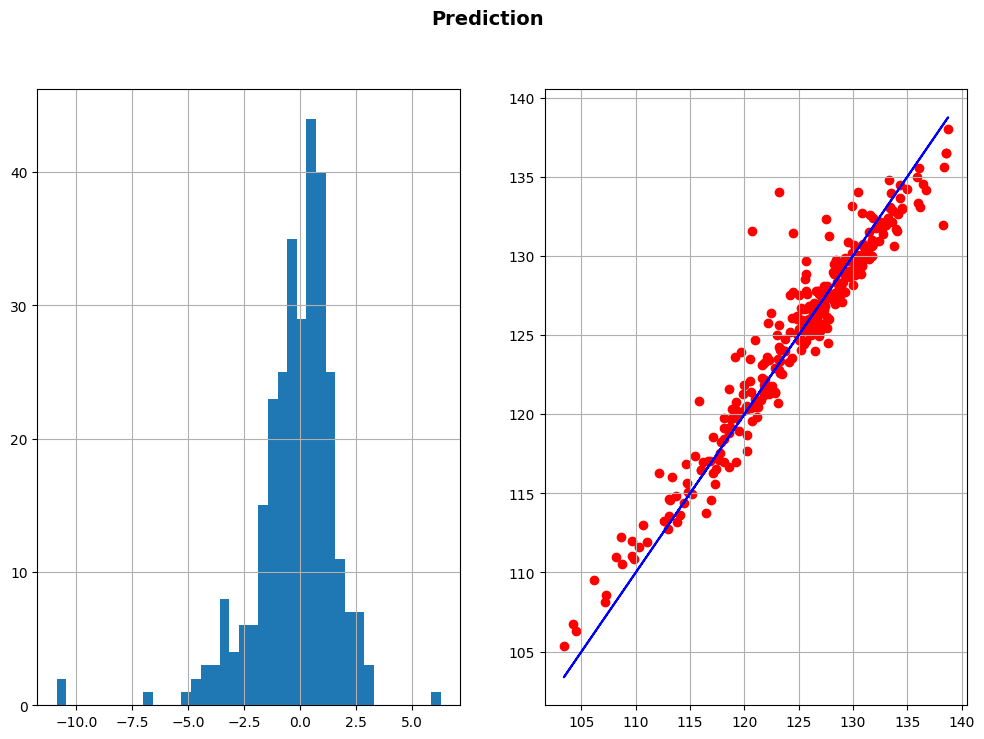

In [ ]:
model.prediction(df_test_y, model.predict(df_test_x))

In [ ]:
model.plot_tree(feature_columns=df_train_x.columns)

The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestRegressor() instead.


# Улучшение модели

In [ ]:
for key, value in vars(model()).items():
    if not key.lower().startswith('_') and not key.lower().endswith('_'):
        if isiter(value) and type(value) is not str:
            print(f'{key}:')
            for v in value:
                print('\t' + f'{v}')
        else:
            print(f'{key}: {value}')

estimator: DecisionTreeRegressor()
n_estimators: 100
estimator_params:
	criterion
	max_depth
	min_samples_split
	min_samples_leaf
	min_weight_fraction_leaf
	max_features
	max_leaf_nodes
	min_impurity_decrease
	random_state
	ccp_alpha
	monotonic_cst
bootstrap: True
oob_score: False
n_jobs: None
random_state: None
verbose: 0
warm_start: False
class_weight: None
max_samples: None
criterion: squared_error
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
min_weight_fraction_leaf: 0.0
max_features: 1.0
max_leaf_nodes: None
min_impurity_decrease: 0.0
ccp_alpha: 0.0
monotonic_cst: None


In [ ]:
param_grid = {'n_estimators': range(30, 100, 5),
              'max_depth': range(5, 50, 5),
              'n_jobs': [-1],
              'verbose': [True]}

In [ ]:
gscv = GridSearchCV(model(), 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    verbose=True)

In [ ]:
%%time
gscv.fit(df_train_x, df_train_y)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished


CPU times: total: 31.3 s
Wall time: 35.5 s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(5, 50, 5),
                         'n_estimators': range(30, 100, 5), 'n_jobs': [-1],
                         'verbose': [True]},
             verbose=True)

In [ ]:
gscv.best_params_

{'max_depth': 40, 'n_estimators': 45, 'n_jobs': -1, 'verbose': True}

In [ ]:
gscv.best_score_

0.9262079751163924

In [ ]:
model = Model(gscv.best_estimator_)
model

RandomForestRegressor(max_depth=40, n_estimators=45, n_jobs=-1, verbose=True)

In [ ]:
model().score(df_test_x, df_test_y)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed:    0.0s finished


0.9277200694120068

## Смещение, весовые коэффициенты и уравнение

In [ ]:
model.intercept_

'RandomForestRegressor' object has no attribute 'intercept_'


In [ ]:
model.coef_

'RandomForestRegressor' object has no attribute 'coef_'


In [ ]:
model.expression

'RandomForestRegressor' object has no attribute 'intercept_'
'RandomForestRegressor' object has no attribute 'coef_'
'NoneType' object is not iterable


# Экспорт модели

In [ ]:
model.save('model_sklearn.pkl')
model()

D:\Programming/Python\ml_tools.py:913: ResourceWarning: unclosed file <_io.BufferedWriter name='model_sklearn.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))


RandomForestRegressor(max_depth=40, n_estimators=45, n_jobs=-1, verbose=True)

# Стэккинг

In [ ]:
stacking = Stacking()

TypeError: Stacking.__init__() missing 1 required positional argument: 'models'

# Бэггинг

In [ ]:
model = model
model

RandomForestRegressor(max_depth=45, n_estimators=90, n_jobs=-1, verbose=True)

In [ ]:
bagging = Bagging(model())

# Бустинг

In [ ]:
boosting = Boosting()

# Нейронная сеть

# Определение последовательности обучения

In [ ]:
normalizer = Normalization(axis=-1)
normalizer

<Normalization name=normalization, built=False>

In [ ]:
normalizer.adapt(np.array(df.drop([target], axis=1)))

In [ ]:
model = Sequential()

model.add(Input(shape=(len(df.columns)-1,)))
model.add(normalizer)
model.add(layers.Flatten())
#model.add(layers.Dense(units=64, activation=activations.relu, input_shape=[len(train_df.keys())]))
#model.add(layers.Dense(units=64, activation=activations.relu))
model.add(layers.Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (72.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 11 (48.00 B)

# Компиляция модели

tf.optimizers.

1) SGD  # Классический оптимизатор, который обновляет веса в направлении антиградиента функции потерь
2) Adam  # Оптимизатор, сочетающий в себе преимущества адаптивного градиентного спуска (Adagrad) и Root Mean Square Propagation (RMSprop).
3) RMSprop  # Оптимизатор адаптирует скорость обучения для каждого параметра на основе истории градиентов для этого параметра.
4) Adagrad  # Оптимизатор уменьшает скорость обучения для параметров, которые редко или никогда не обновлялись, и увеличивает скорость обучения для параметров, которые часто обновлялись
5) Adadelta  # Оптимизатор является расширением Adagrad и использует только последние градиенты для обновления параметров.
6) Adamax  # Оптимизатор является вариантом Adam, который использует бесконечную норму вместо L2 нормы для обновления параметров.
6) Nadam  # Оптимизатор является комбинацией методов Nesterov Accelerated Gradient (NAG) и Adam

In [ ]:
learning_rate = 0.1
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
loss = 'mae'
metrics =  ['mae', 'mse']

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Обучение модели

In [ ]:
epochs = 100
batch_size = 32
verbose = False  # динамическое прогресс

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose),
             keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
             keras.callbacks.TerminateOnNaN()]

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    validation_data=(test_features, test_labels),
    #validation_split = 0.2,  # данные ранее не были разделены на тренировочные и тестовые
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose)

NameError: name 'train_features' is not defined

# Анализ обучения

In [ ]:
max(history.epoch)

NameError: name 'history' is not defined

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file exporting

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file has created!
"export2" elapsed 0.6287 seconds


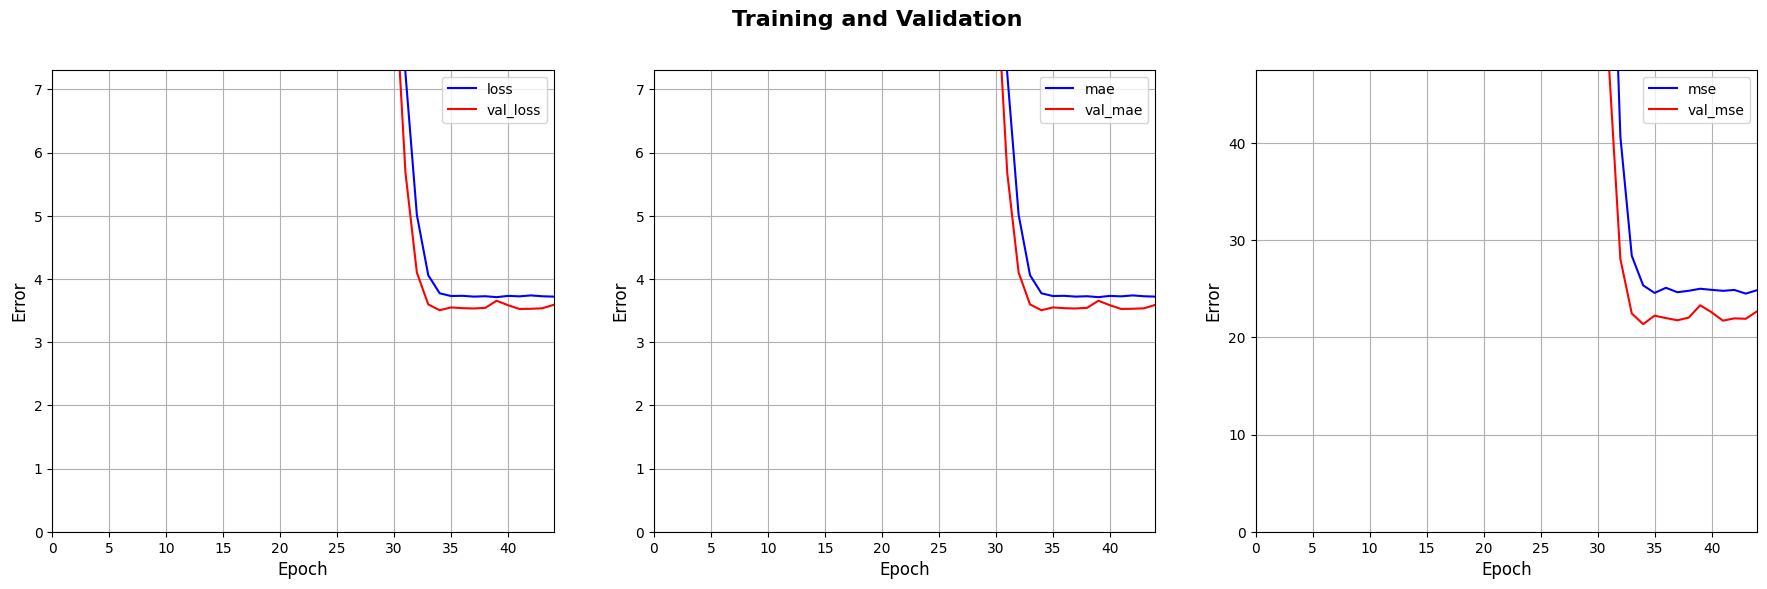

In [ ]:
training_plot(history, figsize=(22, 6), savefig=True)

In [ ]:
hist = pd.DataFrame(history.history)
hist.index.rename('epoch', inplace=True)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
epoch,,,,,,
40,3.731460,3.731460,24.892157,3.584832,3.584832,22.586573
41,3.724472,3.724472,24.791647,3.524654,3.524654,21.720863
42,3.739250,3.739250,24.881523,3.527941,3.527941,21.956928
43,3.725824,3.725824,24.504259,3.535240,3.535240,21.913393
44,3.720477,3.720477,24.856880,3.589997,3.589997,22.687698


Оценка производительности модели

In [ ]:
test_results = dict()
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
test_results

{'model': [3.5899970531463623, 3.5899970531463623, 22.687698364257812]}

In [ ]:
test_predictions = model.predict(test_features.to_numpy()).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/predictions_plot.png" file has created!
"export2" elapsed 0.3761 seconds


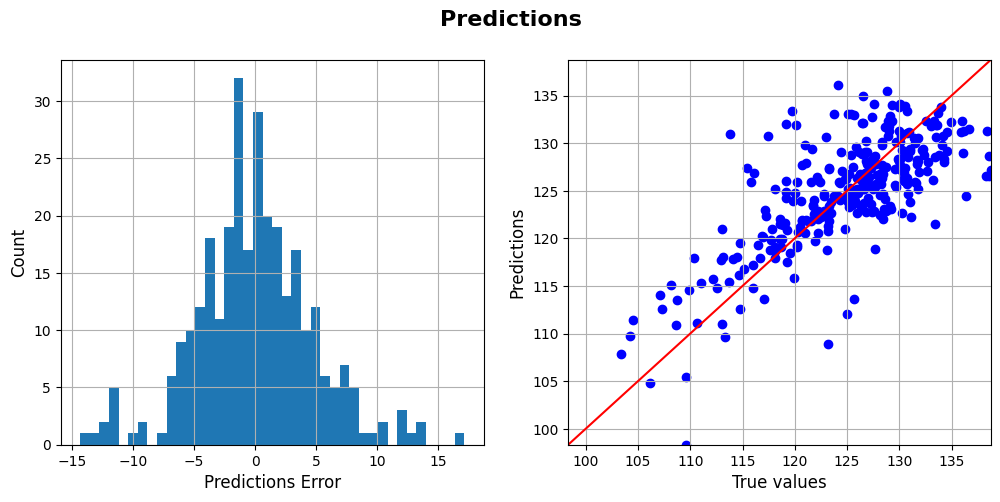

In [ ]:
predictions_plot(test_labels, test_predictions, figsize=(12, 5), savefig=True)

# Экспорт модели

In [ ]:
model_name = 'model_tf'
model_name += '.keras'

In [ ]:
if model_name not in os.listdir(): 
    model.save(model_name)
    print('model has saved')
else:
    print('model has not saved!')

model has not saved!


In [ ]:
os.path.exists(model_name)

True

In [ ]:
model.save(model_name)

# Тестирование

# Импорт модели

In [ ]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise.ipynb',
 'exports',
 'checkpoints',
 '.git',
 'log.csv',
 '.ipynb_checkpoints',
 'model_sklearn.pkl',
 'model_tf.keras',
 'model_airfoil_noise.pkl',
 '.gitignore']

In [ ]:
model_sklearn = Model().load('model_sklearn.pkl')
model_tf = keras.models.load_model('model_tf.keras')

D:\Programming/Python\ml_tools.py:538: ResourceWarning: unclosed file <_io.BufferedReader name='model_sklearn.pkl'>
  self.__model = pickle.load(open(path, 'rb'))


## Автоматическое тестирование

In [ ]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_sklearn.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

,Pressure level [db],Predicted Pressure level [db]
0,126.201,126.8294
1,125.201,126.9896
2,125.951,126.2890
3,127.591,127.5098
4,127.461,127.1850
...,...,...
1498,110.264,110.5941
1499,109.254,109.1609
1500,106.604,107.3443
1501,106.224,106.8600


In [ ]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_tf.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


,Pressure level [db],Predicted Pressure level [db]
0,126.201,127.068253
1,125.201,126.753403
2,125.951,126.359833
3,127.591,125.808838
4,127.461,125.179131
...,...,...
1498,110.264,115.717598
1499,109.254,114.694321
1500,106.604,113.356186
1501,106.224,111.781921


## Ручное тестирование

In [ ]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [ ]:
airfoil_props = {"Frequency [Hz]": [1000], 
                 "Attack angle [deg]": [4], 
                 "Chord length [m]" : [0.2], 
                 "Free-stream velocity [m/s]": [40], 
                 "Thickness [m]": [0.09]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,1000,4,0.2,40,0.09


In [ ]:
%%time
for predict in model_tf.predict(airfoil_props.to_numpy()):
    print(f'Pressure level [db]: {predict[0]} ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Pressure level [db]: 112.1446762084961 
CPU times: total: 78.1 ms
Wall time: 73 ms


In [ ]:
pd.concat([airfoil_props, pd.DataFrame(model_sklearn.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

c:\Python\Python 3.11.9\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,1000,4,0.2,40,0.09,117.0884


In [ ]:
pd.concat([airfoil_props, pd.DataFrame(model_tf.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,1000,4,0.2,40,0.09,112.144676


# Экспорт лучшей модели

In [ ]:
model_sklearn.save('model_airfoil_noise.pkl')

D:\Programming/Python\ml_tools.py:535: ResourceWarning: unclosed file <_io.BufferedWriter name='model_airfoil_noise.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))
